# Damped Lyman-$\alpha$ Absorption Spectra

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import toolslyman as tl

In [53]:
from astropy import units as u
from tqdm import tqdm

In [ ]:
from scipy import special

from toolslyman.constants import *
from toolslyman.cosmology_calc import *
from toolslyman import cosmology

def column_density_along_skewer(z_source, xHI, dn, dr, X_H=0.76, cosmo=None):
    if dn.min()>1:
        dn = dn/dn.mean()-1

    if cosmo is None:
        cosmo = cosmology.cosmo
    
    try:
        dr = dr.to('cm')
    except:
        dr *= u.Mpc
        print('The comoving cell distance (dr) is assumed to be in Mpc unit.')

    nH = (1+dn)*(X_H*cosmo.Ob0*cosmo.critical_density0/(const.m_p+const.m_e)).to('1/cm^3')
    nHI_comving = xHI*nH
    if nHI_comving.ndim==1:
        nHI_comving = nHI_comving[None,:]
    N_HI = (1+z_source)**(-4)*np.cumsum(nHI_comving*dr, axis=1)
    return N_HI

def optical_depth_lyA_along_skewer(z_source, xHI, dn, dr, temp=1e4*u.K, X_H=0.76, cosmo=None, f_alpha=0.4164, lambda_bins=1000, damped=True):
    if cosmo is None:
        cosmo = cosmology.cosmo
    
    try:
        dr = dr.to('cm')
    except:
        dr *= u.Mpc
        print('The comoving cell distance (dr) is assumed to be in Mpc unit.')
        
    try:
        temp = temp.to('K')
    except:
        temp *= u.K
        print('The temperature is assumed to be in Kelvin unit.')
    
    r_src = cosmo.comoving_distance(z_source)
    r_arr = r_src-dr*(np.arange(xHI.shape[0])+1)
    z_arr = cdist_to_z(r_arr, cosmo=cosmo)
    
    lambda_0 = 1215.67*u.AA
    if isinstance(lambda_bins,(int,float)):
        lambda_obs = np.linspace(1100, 1300, lambda_bins)*u.AA*(1+z_source)
    else:
        try:
            lambda_obs = lambda_bins.to('AA')
        except:
            lambda_obs = lambda_bins*u.AA
            print('The wavelength bins (lambda_bins) provided are assumed to be in Angstrom unit.')


    # Setup physical constants
    m_H = const.m_p.to('g')
    kboltz = const.k_B.to('erg/K')
    # sigma_T = const.sigma_T.to('cm^2')
    # sigma_0 = (np.sqrt(3 * np.pi * sigma_T / 8) * 1e-8 * lambda_0 * f_alpha).to('cm^2')

    # Doppler parameter
    bpar = np.sqrt(2 * kboltz * temp / m_H).to('cm/s')
    # Cpar = (sigma_0 * const.c).to('cm^3/s')

    # Optical depth normalization
    prefactor = (np.sqrt(np.pi) * const.e.esu**2 * f_alpha * lambda_0) / (const.m_e * const.c * bpar)
    prefactor = prefactor.to('cm^2')  # absorption cross-section
    Cpar = prefactor*bpar

    # Convert wavelength grid to redshift grid
    # z_grid = lambda_obs / lambda_0 - 1
    tau_lambda = np.zeros_like(lambda_obs.value)

    n_arr = len(z_arr)
    for i, z in tqdm(enumerate(z_arr)):
        z = z_arr[i]
        lam_rest = lambda_obs / (1 + z)
        u_i = ((lam_rest / lambda_0 - 1) * const.c / bpar).to('').value
        apar = (6.25e8 / u.s * lambda_0 / (4 * np.pi * bpar)).to('').value
        if i%10==0:
            print(f"{i+1}/{n_arr} | Lyman-alpha wavelength={(lambda_0*(1+z)).to('AA').value:.1f}AA at z={z:.3f}")
        if damped:
            H_a = special.voigt_profile(u_i, np.sqrt(0.5), apar)
        else:
            H_a = np.exp(-u_i ** 2) / np.sqrt(np.pi)

        nH = (1 + dn[i]) * (X_H * cosmo.Ob0 * cosmo.critical_density0 / (const.m_p + const.m_e)).to('1/cm^3')
        nHI = xHI[i] * nH
        dN_HI = nHI * dr
        tau_0 = (Cpar * dN_HI / bpar).to('').value
        tau_lambda += tau_0 * H_a

    return tau_lambda, lambda_obs


## Toy model

In [35]:
dr = 0.5*u.Mpc
r_bins = np.arange(0,50,dr.to('Mpc').value)*u.Mpc 
xhi_bins = np.ones_like(r_bins.value)*1e-4
xhi_bins[r_bins.to('Mpc').value>20] = 1 

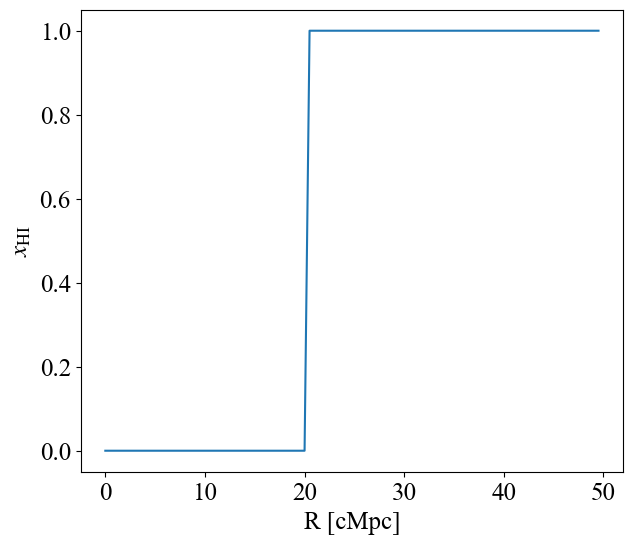

In [36]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.plot(r_bins, xhi_bins)
ax.set_xlabel(r'R [cMpc]')
ax.set_ylabel(r'$x_\mathrm{HI}$')
plt.show()

In [37]:
z_source = 8.76
dn_bins = np.zeros_like(xhi_bins)
N_HI = column_density_along_skewer(z_source, xhi_bins, dn_bins, dr, X_H=0.76, cosmo=None)
dn_bins.shape, N_HI.shape

((100,), (1, 100))

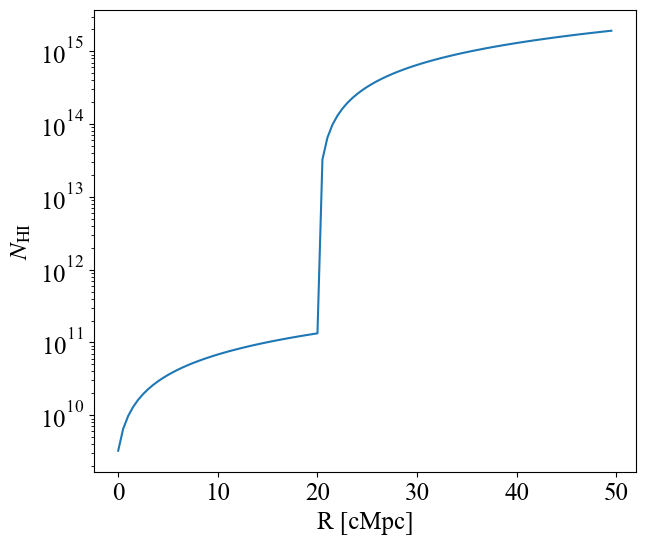

In [38]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.semilogy(r_bins, N_HI[0])
ax.set_xlabel(r'R [cMpc]')
ax.set_ylabel(r'$N_\mathrm{HI}$')
plt.show()

In [57]:
tau_lambda, lambda_obs = optical_depth_lyA_along_skewer(z_source, xhi_bins, dn_bins, dr, 
                                                        temp=1e4*u.K, X_H=0.76, cosmo=None, 
                                                        f_alpha=0.4164, lambda_bins=1000, damped=True)
print(tau_lambda.shape, lambda_obs.shape)

100it [00:00, 2819.36it/s]

1/100 | Lyman-alpha wavelength=11862.6AA at z=8.758
11/100 | Lyman-alpha wavelength=11839.3AA at z=8.739
21/100 | Lyman-alpha wavelength=11816.0AA at z=8.720
31/100 | Lyman-alpha wavelength=11792.8AA at z=8.701
41/100 | Lyman-alpha wavelength=11769.6AA at z=8.682
51/100 | Lyman-alpha wavelength=11746.6AA at z=8.663
61/100 | Lyman-alpha wavelength=11723.6AA at z=8.644
71/100 | Lyman-alpha wavelength=11700.6AA at z=8.625
81/100 | Lyman-alpha wavelength=11677.8AA at z=8.606
91/100 | Lyman-alpha wavelength=11654.9AA at z=8.587
(1000,) (1000,)


In [48]:
np.exp(-tau_lambda).min(), np.exp(-tau_lambda).max()

(0.0, 0.999960105359605)

In [49]:
lambda_obs, tau_lambda

(<Quantity [10736.        , 10737.95395395, 10739.90790791, 10741.86186186,
            10743.81581582, 10745.76976977, 10747.72372372, 10749.67767768,
            10751.63163163, 10753.58558559, 10755.53953954, 10757.49349349,
            10759.44744745, 10761.4014014 , 10763.35535536, 10765.30930931,
            10767.26326326, 10769.21721722, 10771.17117117, 10773.12512513,
            10775.07907908, 10777.03303303, 10778.98698699, 10780.94094094,
            10782.89489489, 10784.84884885, 10786.8028028 , 10788.75675676,
            10790.71071071, 10792.66466466, 10794.61861862, 10796.57257257,
            10798.52652653, 10800.48048048, 10802.43443443, 10804.38838839,
            10806.34234234, 10808.2962963 , 10810.25025025, 10812.2042042 ,
            10814.15815816, 10816.11211211, 10818.06606607, 10820.02002002,
            10821.97397397, 10823.92792793, 10825.88188188, 10827.83583584,
            10829.78978979, 10831.74374374, 10833.6976977 , 10835.65165165,
            

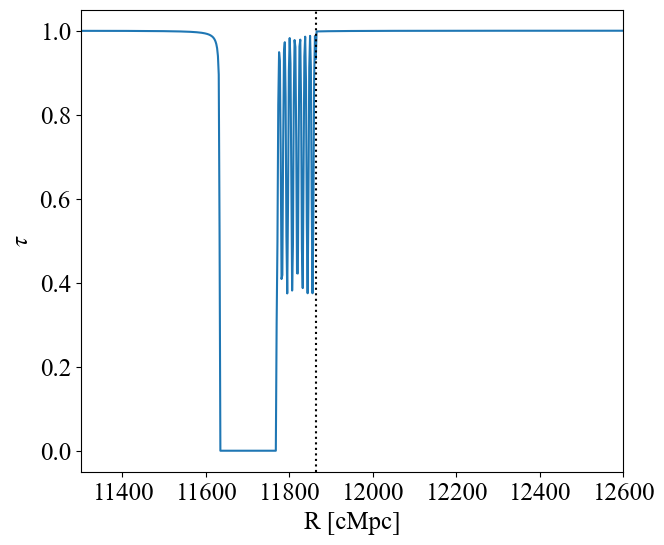

In [50]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.plot(lambda_obs.to('AA').value, np.exp(-tau_lambda))
ax.axvline((1215.67*u.AA*(1+z_source)).value, color='k', ls=':')
ax.set_xlabel(r'R [cMpc]')
ax.set_ylabel(r'$\tau$')
# ax.set_ylim(0,1.1)
ax.set_xlim(11300,12600)
plt.show()

In [23]:
np.exp(-tau_bins)

<Quantity [1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
      

In [ ]:
zqso=7.0
nbins=1000
lam_range=[-600,100]

Create the wave length, redshift, velocity and distance arrays

In [5]:
lam_qso=lambdahi * (1 + zqso) # Lyman-alpha wavelength at the quasar redshift
lambda_wl=lam_qso+lam_range[0]+np.arange(nbins)/(nbins-1)*(lam_range[1]-lam_range[0]) # wavelength array in Å
redshift=lambda_wl/lambdahi-1 # redshift array
veloc=c*(lambda_wl/lam_qso-1) # velocity array
HubbleZ=H0*np.sqrt(OmegaM*(1+zqso)**3+(1-OmegaM)) # H(z)
dist=veloc/HubbleZ # distance in pMpc

Calculate the density, velocities, temperatures and distances between cells.

In [6]:
dr1=np.diff(dist); dr=np.append(dr1,0)    # proper distance between two wavelength bins
nh       = NHydrogen * (1.+redshift)**3   # neutral density [particles / cm^3)
xvel_in  = veloc / km                     # velocity range [km/s]
xvel_out = xvel_in                        # velocity range [km/s]
temp     = 1e4*np.ones(veloc.size)        # IGM temperature [K}

Define neutral hydrogen fraction array

In [7]:
xHI      = np.zeros(veloc.size)

Toy problem: fully neutral away from the QSO, highly ionized in the near zone, completely ionized inside the quasar (redwards of Lyman-alpha

In [8]:
xHI[0:500]=1.; xHI[501:]=1e-7
red_indx = np.where(veloc > 0)
xHI[red_indx]=0 

Calculated the column densities of the cells and plot this

(1000,)


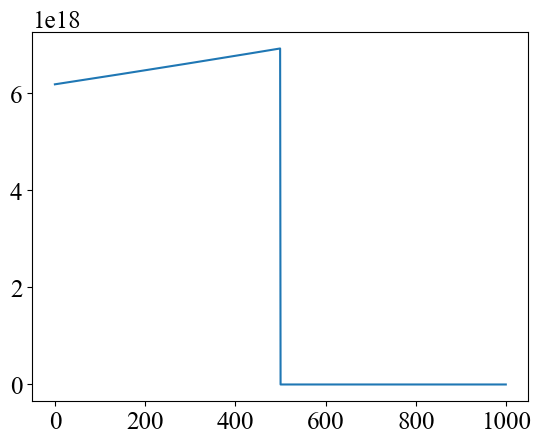

In [12]:
cdens    = nh * dr * xHI
print(cdens.shape)
plt.plot(cdens)

Import the function to calculate the optical depth at each wavelength

In [10]:
#import compute_spectrum
import toolslyman as tl

Calculate the Lyman-alpha optical depth at each wavelength, both with and without the damping wing effect

In [ ]:
tau_d = tl.compute_damped_lyman_alpha_spectrum(cdens,xvel_in,xvel_out,temp,0.4164,damped=True,periodic=False)
tau_nd = tl.compute_damped_lyman_alpha_spectrum(cdens,xvel_in,xvel_out,temp,0.4164,damped=False,periodic=False)

UnitTypeError: Cannot store quantity with dimension resulting from multiply function in a non-Quantity instance.

Plot the transmission curves

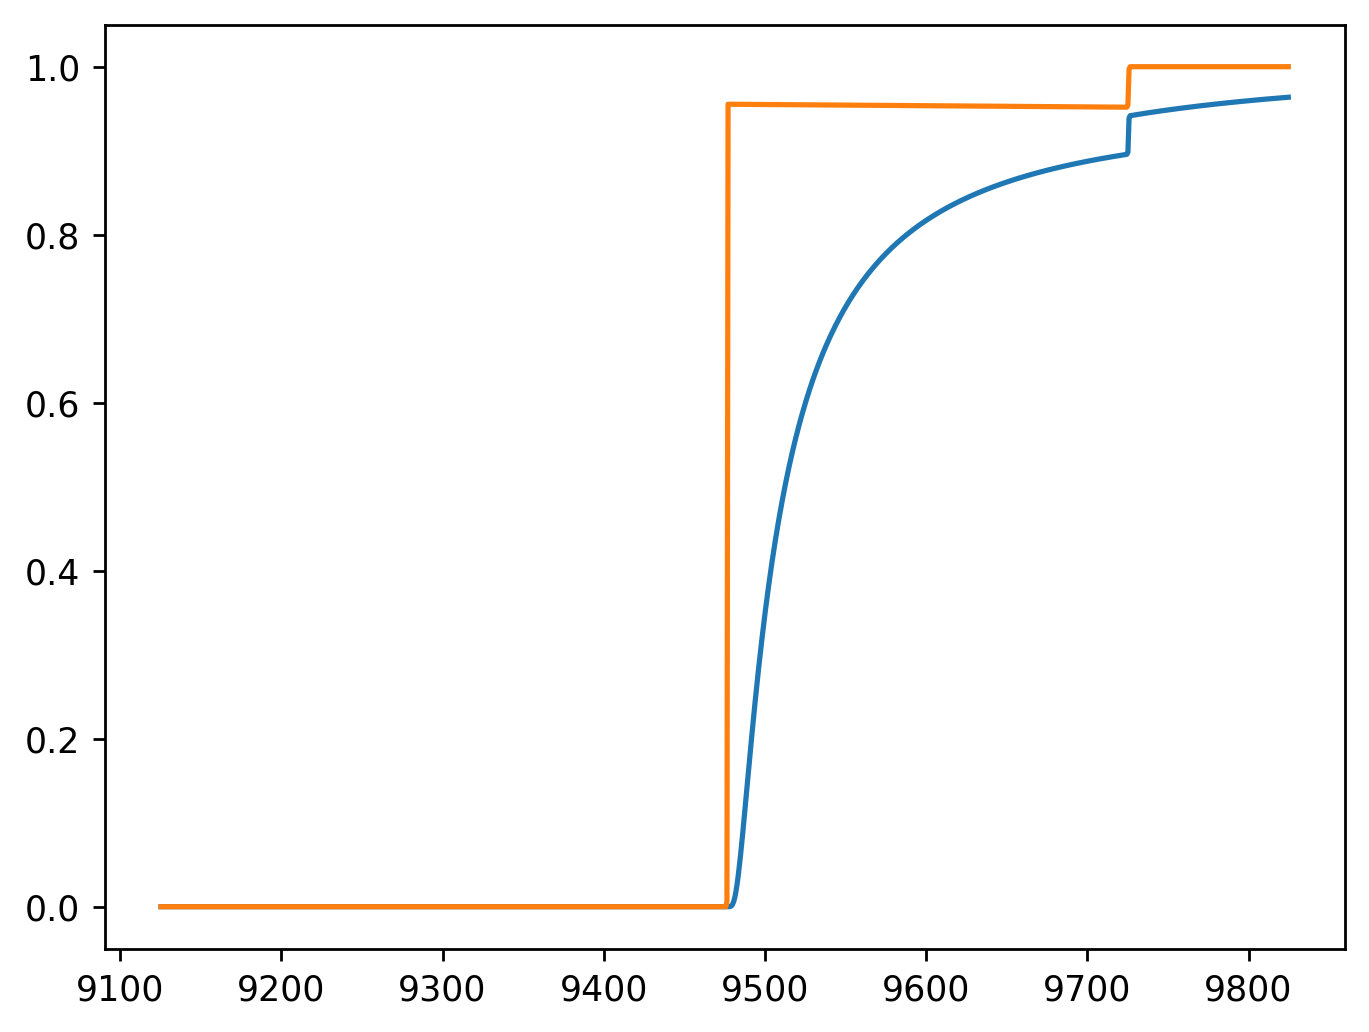

In [73]:
plt.plot(lambda_wl[:-1],np.exp(-tau_d[:-1]))
plt.plot(lambda_wl[:-1],np.exp(-tau_nd[:-1]))